In [1]:
import json
from collections import Counter
import toolz
from IPython.display import Image, HTML
import tqdm

In [2]:
images = json.load(open('/Users/kcarnold/src/ImageCaptioning.pytorch/data/dataset_coco.json'))['images']

In [4]:
id2url = {img['id']: img['coco_url'] for img in
              json.load(open('/Data/COCO/annotations/captions_train2017.json'))['images'] +
              json.load(open('/Data/COCO/annotations/captions_val2017.json'))['images']
         }

In [5]:
Counter(img['split'] for img in images)

Counter({'restval': 30504, 'test': 5000, 'train': 82783, 'val': 5000})

In [6]:
images_by_split = toolz.groupby('split', images)
valid_images = images_by_split['val']
len(valid_images)

5000

In [9]:
def coco_url(cocoid):
    return id2url[cocoid]
#     return f'http://images.cocodataset.org/train2017/{cocoid:012d}.jpg'

In [10]:
coco_url(valid_images[0]['cocoid'])

'http://images.cocodataset.org/train2017/000000184613.jpg'

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

In [12]:
vectorizer = TfidfVectorizer(analyzer=lambda image: [tok for sent in image['sentences'] for tok in sent['tokens']], min_df=5)
vectorizer.fit(images)
valid_img_by_word = vectorizer.transform(images_by_split['val'])

In [13]:
valid_img_by_word

<5000x9976 sparse matrix of type '<class 'numpy.float64'>'
	with 137478 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.cluster import AffinityPropagation

In [15]:
af = AffinityPropagation().fit(valid_img_by_word)

In [17]:
af.cluster_centers_indices_[0]

11

In [21]:
print('\n'.join(toolz.pluck('raw', images_by_split['val'][11]['sentences'])))

A cat on the lid of a toilet looking perturbed.
A blurry picture of a cat standing on a toilet.
A cat standing on the toilet bowl seat
A cat is perched on the top of a toilet seat in the bathroom.
A cat standing on a toilet with an open lid.


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
np.sum(af.labels_ == 0)

12

(array([110., 116.,  80.,  32.,  21.,  11.,   2.,   2.,   2.,   1.]),
 array([ 2. ,  7.7, 13.4, 19.1, 24.8, 30.5, 36.2, 41.9, 47.6, 53.3, 59. ]),
 <a list of 10 Patch objects>)

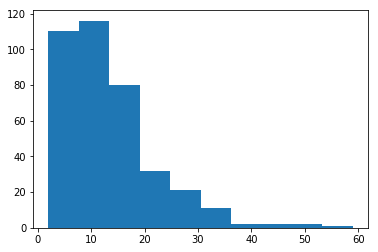

In [32]:
plt.hist(np.bincount(af.labels_))

In [41]:
np.argsort(np.bincount(af.labels_))

array([284, 336, 311, 287,  65, 226, 114, 115,  14, 303, 295, 281, 203,
       266,  59, 276,   1, 298, 286, 154,  76, 136, 375, 334, 353,  16,
       373,  11, 109, 237, 272, 134, 133, 268, 201, 265, 332, 359, 135,
       344, 224, 259, 358,  88,  89,  92,  53, 119,  52, 342,  34, 163,
       302,  18,  25,  49, 186,  29, 320, 250, 249, 324, 357,  93,  77,
       293, 294, 229, 173, 223, 220, 192, 306, 238,  24, 262,  47,  62,
        75, 285, 343, 151, 263, 264,  71,  51, 370,  48, 331, 329, 202,
       200, 162, 270, 159,   2, 104, 371, 335, 152,  78, 283,  80, 187,
       257,  66, 253, 339, 337,  67, 251, 219, 138, 291, 309,   6,  84,
       118, 241, 338, 355, 103, 189, 233, 243,  41, 231,  42, 155,  57,
       184, 141, 185, 171, 144, 196, 182, 254, 206, 317, 288,  31, 282,
       313, 277, 368, 199,  54,   3,  70, 362, 260,  79,  94, 326, 101,
       105, 113, 218, 125, 301,  10, 274, 278, 261, 305, 169, 315, 129,
        27, 161, 117, 150, 366,  97,   7,  74, 132, 256, 217, 19

In [54]:
np.argsort(af.affinity_matrix_[af.cluster_centers_indices_[157]][af.labels_ == 157])

array([20, 39, 34,  6, 41, 14,  5,  3, 46, 40, 37,  7,  2, 26, 36, 38, 22,
        0, 32, 50, 27, 23, 57, 11, 44, 28, 21, 24,  9, 53, 13, 56, 33,  8,
       48,  1, 35, 29, 52, 10, 43, 45, 58, 51,  4, 17, 18, 54, 49, 30, 47,
       12, 16, 15, 42, 55, 19, 31, 25])

In [87]:
def show_images(indices):
    valid_images = images_by_split['val']
    def img(idx):
        img = valid_images[idx]
        captions = '\n'.join(
            '<div>{}</div>'.format(sent)
            for sent in toolz.pluck('raw', img['sentences'])
        )
        return '<div style="display: inline-block;"><img src="{}">{}</div>'.format(coco_url(img['cocoid']), captions)

    return '\n'.join(img(idx) for idx in indices)


In [88]:
def show_cluster(cluster, n=20):
    valid_images = images_by_split['val']
    def img(idx):
        img = valid_images[idx]
        captions = '\n'.join(
            '<div>{}</div>'.format(sent)
            for sent in toolz.pluck('raw', img['sentences'])
        )
        return '<div style="display: inline-block;"><img src="{}">{}</div>'.format(coco_url(img['cocoid']), captions)

    members = np.flatnonzero(af.labels_ == cluster)
    cluster_center = af.cluster_centers_indices_[cluster]
#     indices.remove(cluster_center)
#     indices.insert(0, cluster_center)
    affinity_row = af.affinity_matrix_[af.cluster_centers_indices_[cluster]]
    indices = members[np.argsort(affinity_row[members])[::-1]]
    print(indices.tolist().index(cluster_center))
    total_imgs = len(indices)
    indices = indices[:n]
#     print('\n\n'.join(
#             '\n'.join(toolz.pluck('raw', images_by_split['val'][idx]['sentences']))
#             for idx in indices))
    return HTML(f'<div><p>{total_imgs} images in cluster {cluster}</p>' 
#                 + '\n'.join(img(idx) for idx in indices)
                + show_images(indices)
                + '</div>')
show_cluster(30)

0


# Similar Pairs

In [79]:
import scipy.sparse

In [82]:
sims = scipy.sparse.triu(valid_img_by_word.dot(valid_img_by_word.T), 1)
sims = sims.tocoo()

In [83]:
sims

<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 12497377 stored elements in COOrdinate format>

In [84]:
sorts = np.argsort(sims.data)[::-1]
sorts[-10:]

array([  757979,  2328953,  3834256, 12288405, 11674940,  6863350,
        2660571,  9672436, 11090967,  3834255])

In [109]:
def get_most_similar_unique_pairs(sim_matrix_coo, num_pairs):
    similar_pairs = []
    used_images = set()
    for data_idx in np.argsort(sim_matrix_coo.data)[::-1]:
        a = sim_matrix_coo.row[data_idx]
        b = sim_matrix_coo.col[data_idx]
        if a in used_images or b in used_images:
            continue
        used_images.add(a)
        used_images.add(b)
        similar_pairs.append((a, b))
        if len(similar_pairs) == num_pairs:
            break
    return similar_pairs
similar_pairs = get_most_similar_unique_pairs(scipy.sparse.triu(valid_img_by_word.dot(valid_img_by_word.T), 1).tocoo(), 12)

In [110]:
similar_pairs

[(836, 3414),
 (3322, 3323),
 (2622, 4295),
 (563, 1758),
 (1642, 3163),
 (3716, 3835),
 (4352, 4353),
 (489, 1614),
 (2024, 3063),
 (472, 1968),
 (1370, 3440),
 (1894, 3559)]

In [111]:
HTML('\n'.join(show_images(pair) for pair in similar_pairs))

In [114]:
x = list(range(10))
np.random.RandomState(0).shuffle(x)
x

AttributeError: 'mtrand.RandomState' object has no attribute 'shuffled'

In [115]:
def get_stimulus_images():
    sim_matrix_coo = scipy.sparse.triu(valid_img_by_word.dot(valid_img_by_word.T), 1).tocoo()
    similar_pairs = list(map(list, get_most_similar_unique_pairs(sim_matrix_coo, 12)))
    rs = np.random.RandomState(0)
    rs.shuffle(similar_pairs)
    for pair in similar_pairs:
        rs.shuffle(pair)
    return similar_pairs
stimuli = get_stimulus_images()

In [116]:
HTML('\n'.join(show_images(pair) for pair in stimuli))

# Here are the images that we're using in the experiment!

In [118]:
[[valid_images[i]['cocoid'] for i in pair] for pair in stimuli]

[[275449, 349130],
 [396295, 301595],
 [431140, 341011],
 [227326, 523217],
 [200451, 313214],
 [223777, 401320],
 [247576, 315976],
 [71815, 240739],
 [240275, 476864],
 [527375, 164170],
 [236272, 467791],
 [280480, 440500]]

In [100]:

vectorizer.idf_[vectorizer.vocabulary_['person']]

3.0180957701134536

In [77]:
def show_caps(indices):
    print('\n\n'.join(
        '\n'.join([sent['raw'] for sent in images_by_split['val'][idx]['sentences']])
        for idx in indices))

In [104]:
valid_images[836]['cocoid']

236272

In [95]:
# HTML(show_images([153, 3323]))
# HTML(show_images([489, 1614]))
HTML(show_images([836, 1508]))
# HTML(show_images([4352, 4353]))

In [35]:
[sent['raw'] for sent in images_by_split['val'][0]['sentences']]

['A child holding a flowered umbrella and petting a yak.',
 'A young man holding an umbrella next to a herd of cattle.',
 'a young boy barefoot holding an umbrella touching the horn of a cow',
 'A young boy with an umbrella who is touching the horn of a cow.',
 'A boy holding an umbrella while standing next to livestock.']

In [42]:
np.argsort(sims[0].A[0])[-10:]

array([ 293, 1648,  755, 4121, 3980, 1459, 3607,  943, 2166,    0])

In [53]:
closest_data_indices = np.argsort(sims.data)

In [46]:
from sklearn.metrics import pairwise

In [50]:
pairwise.pairwise_distances_argmin_min(valid_img_by_word[0], valid_img_by_word[1:])


(array([2165]), array([0.91825199]))

In [52]:
[sent['raw'] for sent in images_by_split['val'][2166]['sentences']]

['Young boy holding an umbrella on a rainy day.',
 'The boy is walking in the rain with an umbrella.',
 'a boy holding an umbrella as he walks down the road ',
 'a young boy walks towards the camera holding an umbrella ',
 'A young boy with an umbrella covering on a rainy day']

In [45]:
print('\n\n'.join([
    '\n'.join([sent['raw'] for sent in images_by_split['val'][idx]['sentences']])
    for idx in np.argsort(sims[0].A[0])[-10:][::-1]]))

A child holding a flowered umbrella and petting a yak.
A young man holding an umbrella next to a herd of cattle.
a young boy barefoot holding an umbrella touching the horn of a cow
A young boy with an umbrella who is touching the horn of a cow.
A boy holding an umbrella while standing next to livestock.

Young boy holding an umbrella on a rainy day.
The boy is walking in the rain with an umbrella.
a boy holding an umbrella as he walks down the road 
a young boy walks towards the camera holding an umbrella 
A young boy with an umbrella covering on a rainy day

A woman walking down a street holding an umbrella.
A woman with an umbrella and a man walking.
A woman is standing beside an older gentleman while holding an umbrella.
A woman holding an umbrella while a man walks behind her.
A woman walking with a man and holding an umbrella looks off to the side. 

an image of a woman holding an umbrella with her coat on
A woman holding an umbrella in the rain
A woman holding a white umbrella wi

In [9]:
import h5py

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [30]:
img_data_file = h5py.File('/Users/kcarnold/code/textrec/models-aside/feats_by_imgid.h5')

In [31]:
def get_vec_for_image(cocoid):
    return img_data_file[str(cocoid)][:].mean(axis=0)

In [32]:
mean_features = np.array([get_vec_for_image(img['cocoid']) for img in tqdm.tqdm_notebook(images)])

HBox(children=(IntProgress(value=0, max=123287), HTML(value='')))

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
pdists = pairwise_distances(mean_features)

In [ ]:
def show_similar_images(valid_idx, n=10):
    return '\n'.join(
        '<img src="{}">'.format(coco_url(valid_images[idx]['cocoid']))
        for idx in np.argsort(pdists[valid_idx])[:n])
HTML(show_similar_images(1))

In [18]:
HTML(show_similar_images(3))